# Apprentissage statistique : Cas logistique
## Langage R

## Chargement des packages R necessaires pour executer ce script

In [21]:
rm(list=ls()) # Standard code to clear R's memory

list.of.packages <- c("stringr", "glmnet", "randomForest", "rpart", "rpart.plot", "e1071", "ROCR", "AUC")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos='https://cran.univ-paris1.fr/', quiet = TRUE)

sapply(list.of.packages, library, character.only = TRUE)

stringr,glmnet,randomForest,rpart,rpart.plot,e1071,ROCR,AUC
AUC,AUC,AUC,AUC,AUC,AUC,AUC,AUC
ROCR,ROCR,ROCR,ROCR,ROCR,ROCR,ROCR,ROCR
gplots,gplots,gplots,gplots,gplots,gplots,gplots,gplots
e1071,e1071,e1071,e1071,e1071,e1071,e1071,e1071
rpart.plot,rpart.plot,rpart.plot,rpart.plot,rpart.plot,rpart.plot,rpart.plot,rpart.plot
rpart,rpart,rpart,rpart,rpart,rpart,rpart,rpart
randomForest,randomForest,randomForest,randomForest,randomForest,randomForest,randomForest,randomForest
glmnet,glmnet,glmnet,glmnet,glmnet,glmnet,glmnet,glmnet
foreach,foreach,foreach,foreach,foreach,foreach,foreach,foreach
Matrix,Matrix,Matrix,Matrix,Matrix,Matrix,Matrix,Matrix


# Importation des donnees :

In [22]:
filepath = file.choose(new = FALSE)
sep = readline(prompt = "Enter the type of separator (;/,/tab/space) :")
sep = str_to_lower(sep)
while (sep != 'tab' && sep != 'space' && sep != ';' && sep != ',') {
    sep = readline(prompt = "Enter the type of separator (;/,/tab/space) :")
    sep = str_to_lower(sep)
}
if (sep == 'tab') {
    sep = '\t'
} else if (sep == 'space') {
    sep = ' '
}
print(sep)

Enter the type of separator (;/,/tab/space) :;
[1] ";"


In [23]:
#filepath = "spam.csv" # filepath of your dataset
data = read.table(file = filepath, header = TRUE, sep = sep)

In [24]:
total_rows = nrow(data)
total_columns = ncol(data)
title = names(data) # Récupération du noms des différentes variables

## Analyse descriptive

In [25]:
head(data)

id,make,address,all,num3d,our,over,remove,internet,order,...,charSemicolon,charRoundbracket,charSquarebracket,charExclamation,charDollar,charHash,capitalAve,capitalLong,capitalTotal,type
501,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,...,0,0.000,0,0.000,0.000,0.000,3.000,16,33,spam
502,0.00,0.00,0.00,0,0.00,0.00,0.00,1.12,0.00,...,0,0.204,0,0.408,0.408,0.000,4.100,25,82,spam
503,0.00,0.00,0.48,0,0.48,0.00,0.00,0.48,0.00,...,0,0.084,0,0.084,0.761,0.000,5.322,46,165,spam
504,0.08,0.08,0.76,0,0.85,1.02,0.25,0.17,0.59,...,0,0.063,0,0.394,0.114,0.012,7.540,669,1410,spam
505,0.00,0.00,0.19,0,0.19,0.00,0.00,0.19,0.19,...,0,0.058,0,0.264,0.000,0.000,4.053,93,381,spam
506,0.00,0.35,0.35,0,1.07,0.00,0.00,0.35,0.00,...,0,0.233,0,0.233,0.233,0.000,3.414,25,140,spam


In [26]:
y = readline(prompt = "Enter the exact name of the response variable :")
while (!(y %in% title))
{
  y <- readline(prompt = "This variable doesn't exist! Please make sure to enter the exact name: ")
}
print(y)

Enter the exact name of the response variable :type
[1] "type"


In [27]:
# Vérifier s'il y a une variable identifiant
input4 = readline(prompt = "Vos données ont-elles une variable identifiant pour les individus ? (y/n) : ")     # ici : n
# Passage en minuscule si l'utilisateur rentre Y ou N
input4 = str_to_lower(input4)
# Tant que l'utilisateur n'a pas rentré quelque chose de correct
while (input4 != 'y' && input4 != 'n')
{
  input4 = readline(prompt = "Veuillez entrer y ou n : ")
  input4 = str_to_lower(input4)
}
# S'il y en a une
if (input4 == 'y')
{
  input5 = readline(prompt = "Indiquez le nom de la variable identifiant : ")
  while (!(input5 %in% title) || input5 == y)
  {
    if (!(input5 %in% title))
    {
          input5 = readline(prompt = "Cette variable n'existe pas ! Veuillez vérifier son nom et essayer à nouveau : ")
    } else if (input5 == y)
    {
      input5 = readline(prompt = "Il s'agit de la variable d'intérêt ! Veuillez vérifier et essayer à nouveau : ")
    }
    # On supprime cette variable
  }
  data = data[, ! names(data) %in% input5, drop = F]
  total_columns = total_columns-1
}

Vos données ont-elles une variable identifiant pour les individus ? (y/n) : y
Indiquez le nom de la variable identifiant : id


In [28]:
y = data[y]
y_values = list(y)

In [29]:
cat(dim(data))

500 58

In [30]:
classe = table(y)
nb_classe = length(classe)

cat("Différentes classes de la variable d'intérêt : ")
classe
cat("Nombre de classes : ", nb_classe)

Différentes classes de la variable d'intérêt : 

y
nonspam    spam 
    250     250 

Nombre de classes :  2

In [31]:
input6 = readline(prompt = "Comment sont représentées les données manquantes dans votre dataset (s'il y en a) : ")
# Recherche du nombre de données manquantes dans la matrice du dataset
matrice_dataset = as.matrix(data)
nb_NaN = 0
for (i in 1:nrow(matrice_dataset))
{
    for (j in 1:ncol(matrice_dataset))
    {
        if (matrice_dataset[i,j] == input6)
        {
            nb_NaN = nb_NaN+1
        }
    }
}
cat("Nombre d'éléments manquants = " , nb_NaN)
cat("\nNombre d'éléments dans la matrice = ", length(matrice_dataset))
cat("\nRatio = ",nb_NaN/length(matrice_dataset))

Comment sont représentées les données manquantes dans votre dataset (s'il y en a) : NA
Nombre d'éléments manquants =  0
Nombre d'éléments dans la matrice =  29000
Ratio =  0

### Répartition de la variable d'intérêt

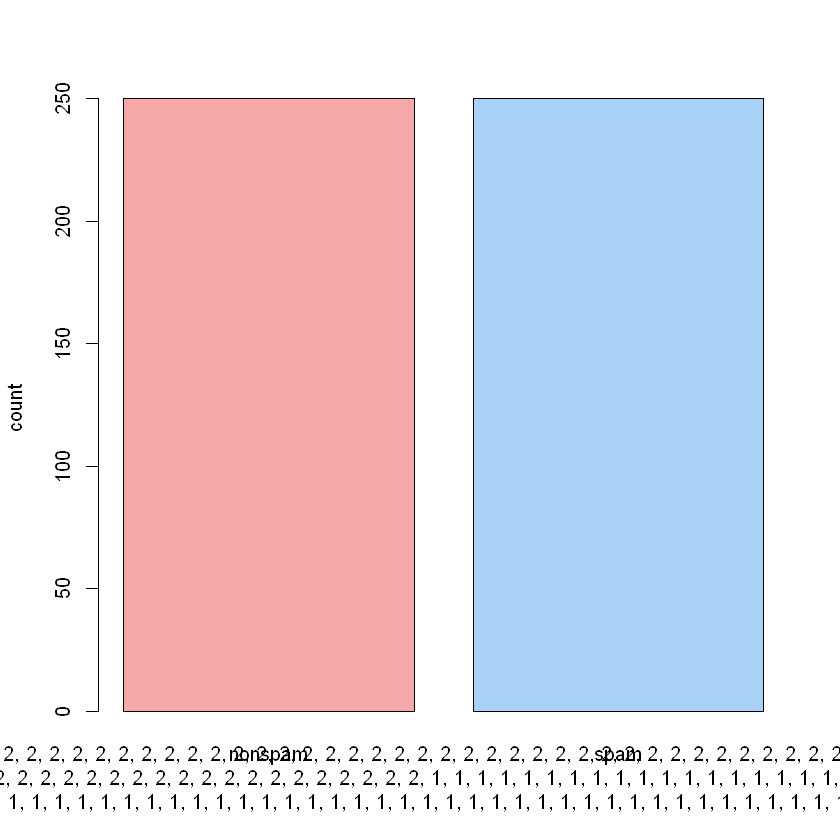

In [32]:
tbl <- with(data, table(y))
barplot(tbl, beside = TRUE, col = c("#F5A9A9", "#A9D0F5"), xlab = y, ylab = "count")

In [33]:
# On code la variable comme un facteur pour pouvoir implémenter les méthodes
y <- factor(unlist(y))

set.seed(1234)
# Division du dataset
index <- sample(1:total_rows, total_rows*(2/3)) 
xTrain = data[index,]
xTest =  data[-index,]
# Vérifications
cat("Dimension du dataset d'apprentissage : ", dim(xTrain))
cat("\nDimension du dataset de test : ", dim(xTest))

Dimension du dataset d'apprentissage :  333 58
Dimension du dataset de test :  167 58

In [34]:
# Récupération des variables explicatives du dataset apprentissage et du dataset test
XTrain = as.data.frame(xTrain[,-total_columns])
XTest = as.data.frame(xTest[,-(total_columns)])
# Vérification
cat("Dataset d'apprentissage : ", dim(XTrain))
head(XTrain)

cat("\nDataset test : ", dim(XTest))
head(XTest)

Dataset d'apprentissage :  333 57

,make,address,all,num3d,our,over,remove,internet,order,mail,...,conference,charSemicolon,charRoundbracket,charSquarebracket,charExclamation,charDollar,charHash,capitalAve,capitalLong,capitalTotal
57,0.33,0.16,0.33,0,0.00,0.16,0,0.16,0.16,0.08,...,0,0.000,0.000,0.000,0.213,0.113,0,3.150,76,441
311,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0.00,...,0,0.000,0.000,0.000,0.000,0.000,0,1.000,1,7
304,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0.00,...,0,0.000,0.507,0.000,0.000,0.000,0,1.133,3,17
310,0.46,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0.00,...,0,0.000,0.125,0.000,0.000,0.000,0,1.510,10,74
428,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0.00,...,0,0.102,0.308,0.000,0.000,0.000,0,1.400,10,77
317,0.00,0.00,1.33,0,1.33,0.00,0,0.00,0.00,0.00,...,0,0.865,0.000,0.216,0.000,0.000,0,1.647,12,28



Dataset test :  167 57

,make,address,all,num3d,our,over,remove,internet,order,mail,...,conference,charSemicolon,charRoundbracket,charSquarebracket,charExclamation,charDollar,charHash,capitalAve,capitalLong,capitalTotal
2,0.00,0.00,0.00,0,0.00,0,0,1.12,0.00,0.00,...,0,0,0.204,0,0.408,0.408,0.000,4.100,25,82
3,0.00,0.00,0.48,0,0.48,0,0,0.48,0.00,0.00,...,0,0,0.084,0,0.084,0.761,0.000,5.322,46,165
10,0.00,0.00,0.00,0,0.00,0,0,4.62,0.00,0.00,...,0,0,0.000,0,0.919,0.367,0.000,2.840,16,71
13,0.00,0.00,0.53,0,0.53,0,0,0.53,0.00,0.00,...,0,0,0.186,0,0.093,0.466,0.000,5.038,60,131
14,0.35,0.08,0.35,0,0.35,0,0,0.52,0.61,1.76,...,0,0,0.081,0,0.556,0.069,0.011,19.234,1170,3116
18,0.00,0.00,0.00,0,0.00,0,0,0.00,0.00,0.00,...,0,0,0.417,0,0.208,0.626,0.000,4.066,17,61


In [35]:
# Isolation de la variable d'intérêt
yTrain = xTrain[,total_columns]
yTrain_values = list(yTrain)

yTest = xTest[,total_columns]
yTest_values = list(yTest)

yTrain
nonspam    spam 
    167     166 

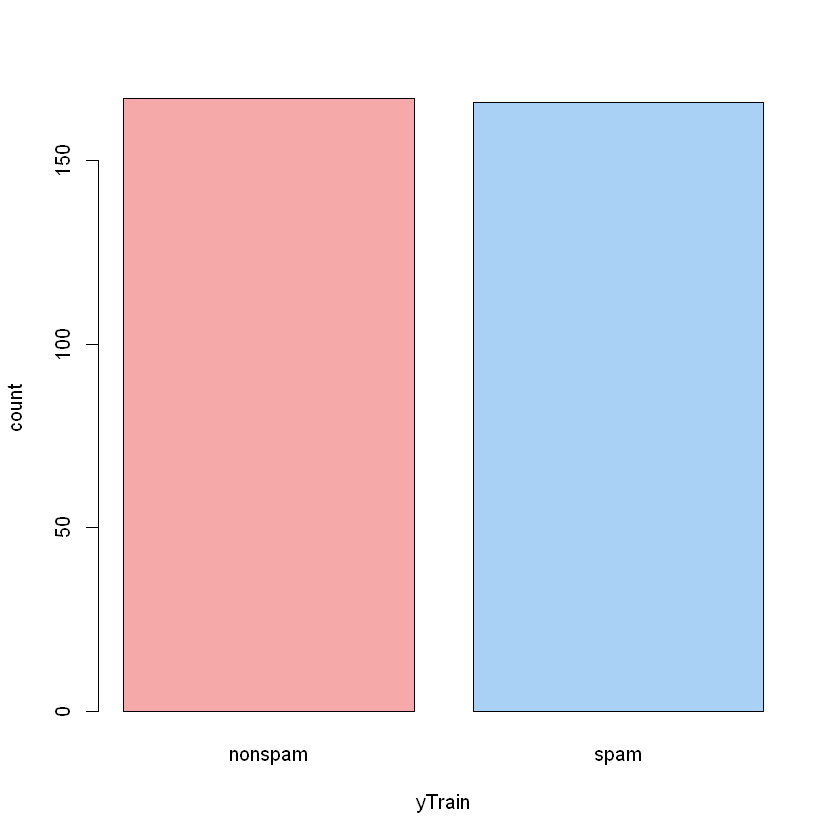

yTest
nonspam    spam 
     83      84 

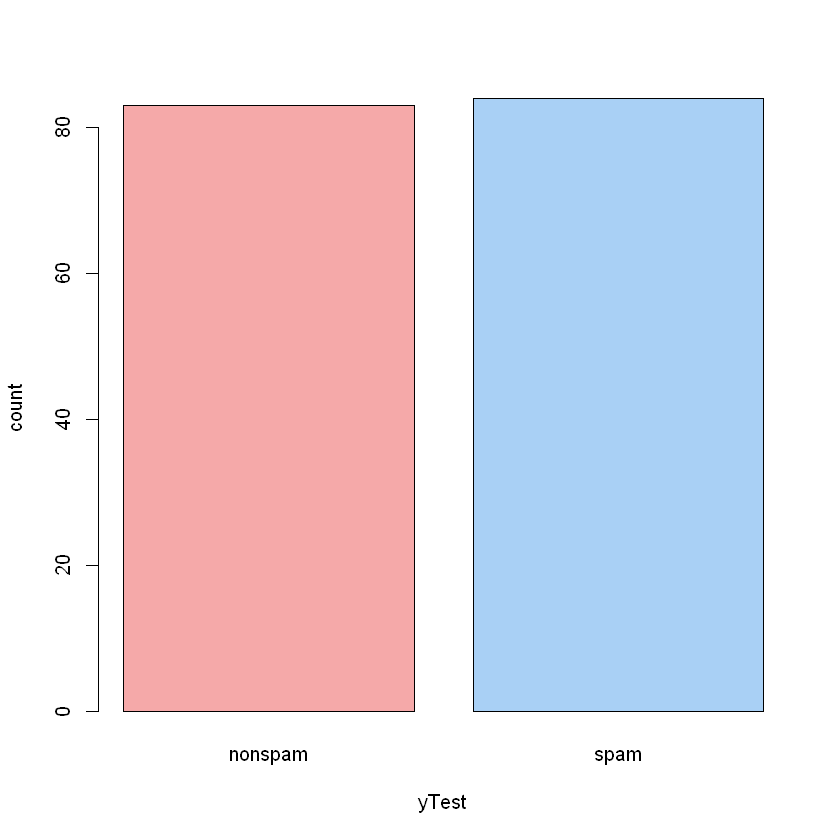

In [36]:
# Vérification que les classes soient bien réparties dans les 2 datasets

# Dataset apprentissage
    # /!\ Représentation graphique ou juste afficher nb_occ, je sais pas
tbl_app <- with(data, table(yTrain))
barplot(tbl_app, beside = TRUE, col = c("#F5A9A9", "#A9D0F5"), xlab = "yTrain", ylab = "count")
table(yTrain)

# Dataset test
tbl_test <- with(data, table(yTest))
barplot(tbl_test, beside = TRUE, col = c("#F5A9A9", "#A9D0F5"), xlab = "yTest", ylab = "count")
table(yTest)

In [37]:
yTrain = as.factor(yTrain)
yTest = as.factor(yTest)
levels(yTrain)[1]<-0
levels(yTrain)[2]<-1
levels(yTest)[1]<-0
levels(yTest)[2]<-1
summary(yTrain)
summary(yTest)
XTrain$y = yTrain
XTest$y = yTest

0   1 
167 166

0  1 
83 84

## Regression Logistique

In [38]:
fit.glm = glm(y ~ ., data = XTrain, family = "binomial")

# Performance du modele
pred.glm = predict(fit.glm, newdata = XTest) # prediction de classification
(score.glm = mean(pred.glm != yTest)) # Erreur de prédiction
probas = pred.glm
pred.glm = rep(0, length(XTest$y))
pred.glm[probas > 0.5] = 1
cat("Erreur de classification")
(classification_error = mean(pred.glm!=XTest$y))

# Matrice de confusion
print("Matrice de confusion :")
table(true = yTest, pred = pred.glm)

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] 1

Erreur de classification

[1] 0.06586826

[1] "Matrice de confusion :"


    pred
true  0  1
   0 76  7
   1  4 80

## Random Forest

In [39]:
tune.rf = tune(randomForest, y ~ ., data = XTrain, ranges = list(ntree = c(500, 2000, 10000), mtry = c(sqrt(total_columns-1), (total_columns-1)/2, sqrt(total_columns-1)/2)))
tune.rf
best.rf = tune.rf$best.model
best.rf.params = tune.rf$best.parameters


Parameter tuning of 'randomForest':

- sampling method: 10-fold cross validation 

- best parameters:
 ntree     mtry
  2000 3.774917

- best performance: 0.03609626 


In [40]:
cat("\ Nombre de vrais positifs : ")
best.rf$confusion[2,2]

cat("\n Nombre de faux positifs : ")
best.rf$confusion[1,2]

cat("\n Nombre de vrais negatifs : ")
best.rf$confusion[1,1]

cat("\n Nombre de faux negatifs : ")
best.rf$confusion[2,1]

cat("\n Erreur OOB : ")
(best.rf$confusion[2,1]+best.rf$confusion[1,2])/
(best.rf$confusion[1,1]+best.rf$confusion[2,2]+best.rf$confusion[2,1]+best.rf$confusion[1,2])

 Nombre de vrais positifs : 

[1] 157


 Nombre de faux positifs : 

[1] 5


 Nombre de vrais negatifs : 

[1] 162


 Nombre de faux negatifs : 

[1] 9


 Erreur OOB : 

[1] 0.04204204

### Classement des variables explicatives:

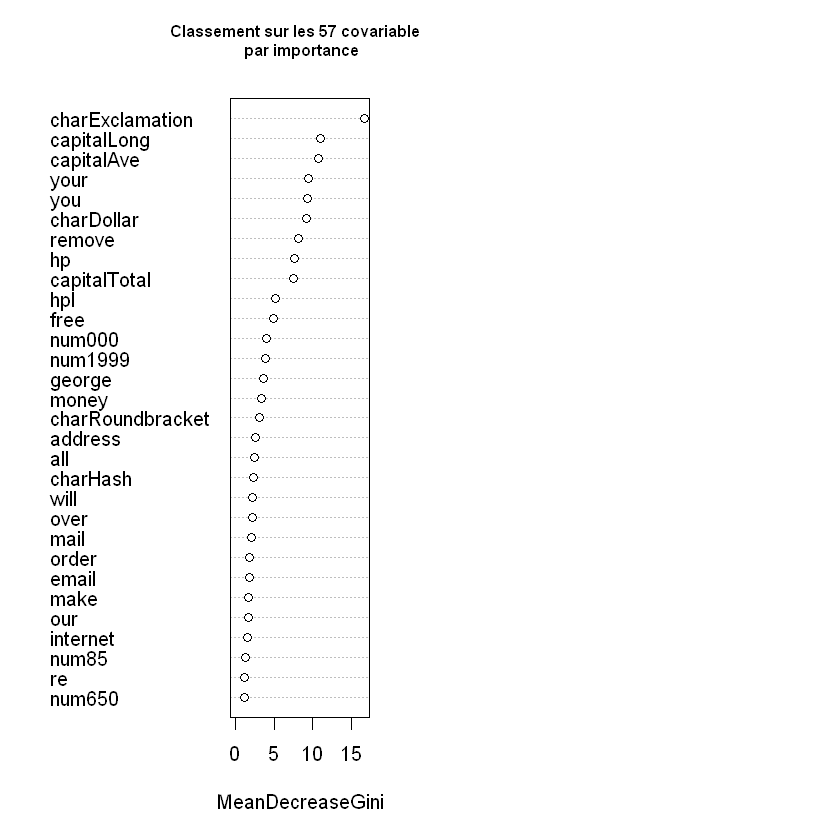

In [41]:
par(mfrow = c(1,2))
varImpPlot(best.rf, main = sprintf("Classement sur les %d covariables\n par importance\n", total_columns-1), cex.main = 0.8)

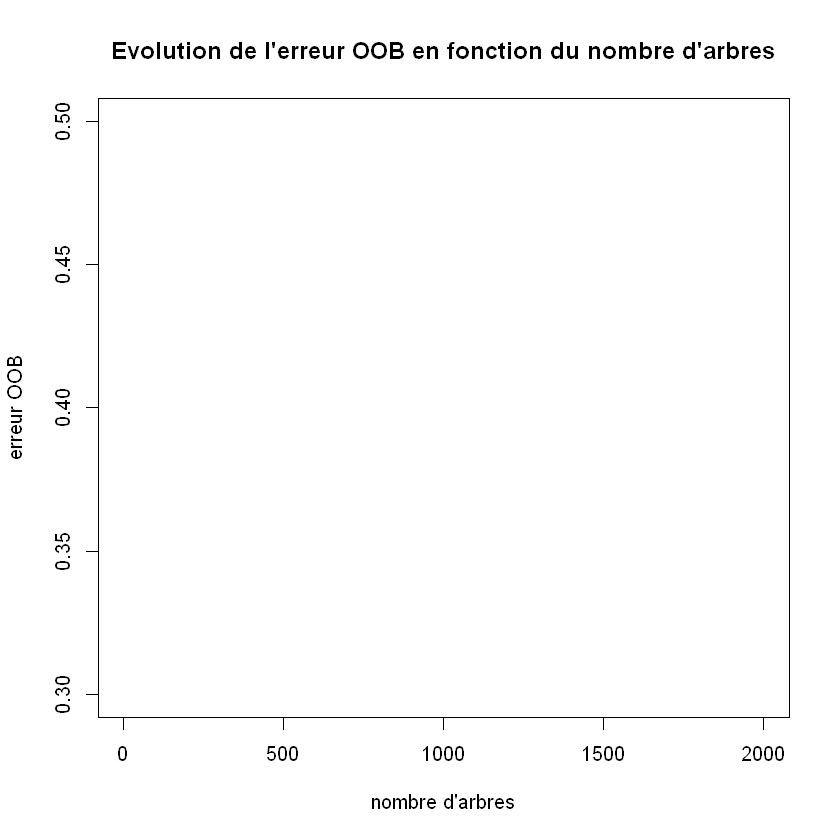

In [42]:
plot(best.rf$err.rate[, 1],type = "l", main = "Evolution de l'erreur OOB en fonction du nombre d'arbres", 
     xlab = "nombre d'arbres", ylab = "erreur OOB", ylim = c(0.30, 0.50))

## CART

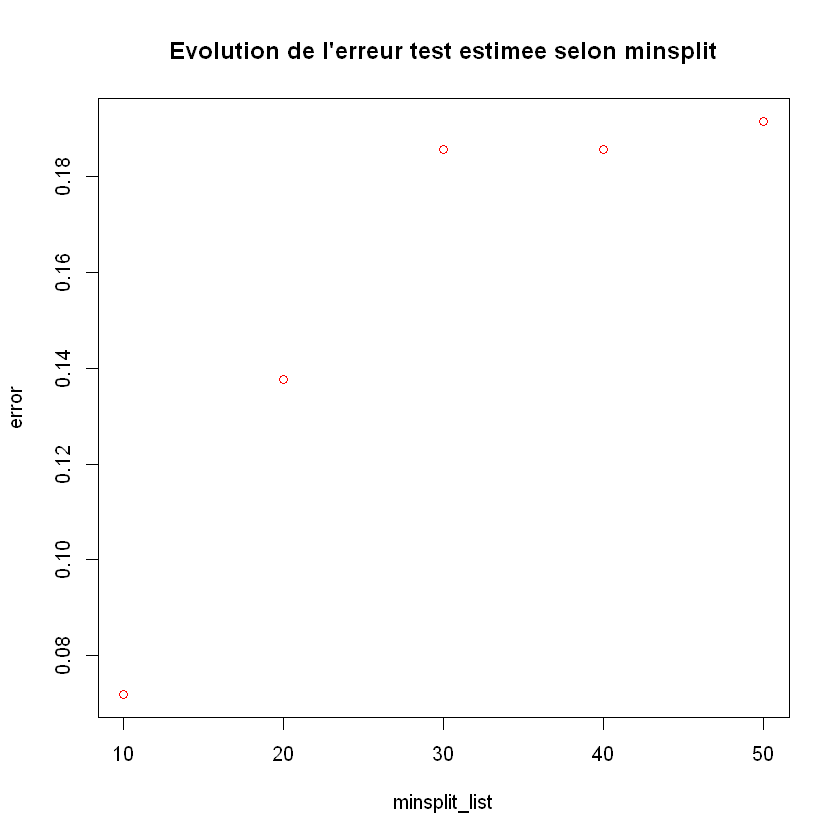

In [43]:
m = c(10,20,30,40,50)
error = rep(NA, length(m))
minsplit_list = c("10","20","30","40","50")
for (j in 1:length(m)) 
{
   cart = rpart(y~., data = XTrain,control=rpart.control(minsplit=m[j],cp=0,xval=10))
   predict_cart = predict(cart, newdata = XTest,  type="class")
   error[j] = mean(XTest$y != predict_cart)
}
error_CART = cbind(minsplit_list, error)
plot(error_CART, main = "Evolution de l'erreur test estimee selon minsplit", col = 2)

In [44]:
(best.minsplit = error_CART[which.min(error_CART[,"error"]),"minsplit_list"])
(best.minsplit = as.numeric(str_extract(best.minsplit, regex("\\d{2}"))))

minsplit_list 
         "10"

[1] 10

n= 333 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 333 166 0 (0.50150150 0.49849850)  
   2) charExclamation< 0.0565 165  23 0 (0.86060606 0.13939394)  
     4) remove< 0.05 159  17 0 (0.89308176 0.10691824)  
       8) capitalAve< 14.25 155  13 0 (0.91612903 0.08387097)  
        16) you< 6.07 152  10 0 (0.93421053 0.06578947)  
          32) money< 0.12 149   8 0 (0.94630872 0.05369128) *
          33) money>=0.12 3   1 1 (0.33333333 0.66666667) *
        17) you>=6.07 3   0 1 (0.00000000 1.00000000) *
       9) capitalAve>=14.25 4   0 1 (0.00000000 1.00000000) *
     5) remove>=0.05 6   0 1 (0.00000000 1.00000000) *
   3) charExclamation>=0.0565 168  25 1 (0.14880952 0.85119048)  
     6) you< 0.16 21   7 0 (0.66666667 0.33333333)  
      12) charDollar< 0.062 15   1 0 (0.93333333 0.06666667) *
      13) charDollar>=0.062 6   0 1 (0.00000000 1.00000000) *
     7) you>=0.16 147  11 1 (0.07482993 0.92517007)  
      14) hp>=0.65 5   1 0 (0.80000000 0

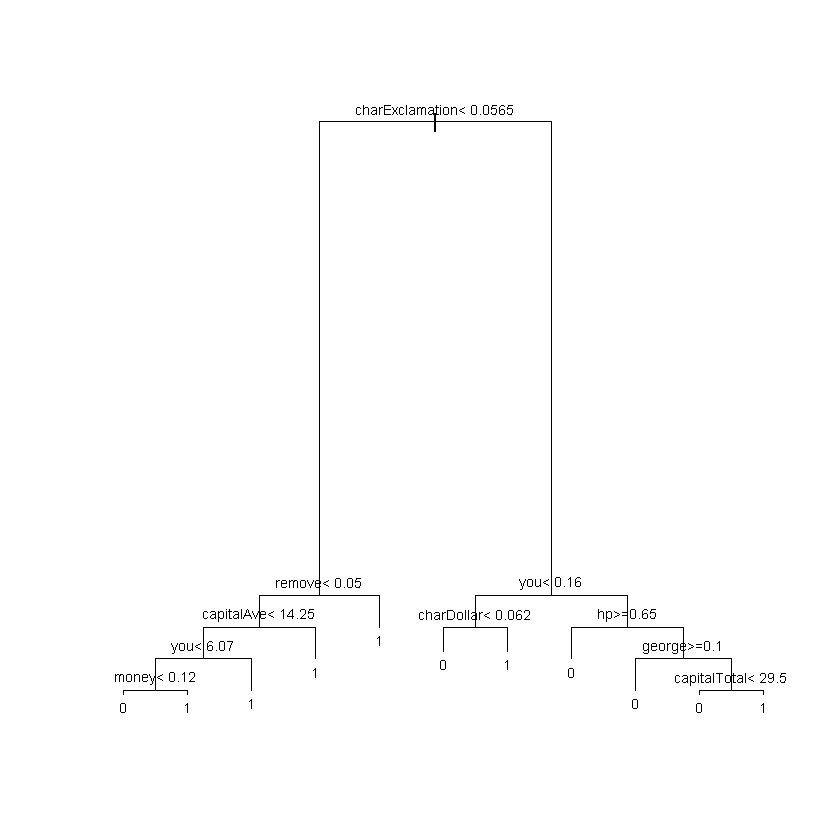

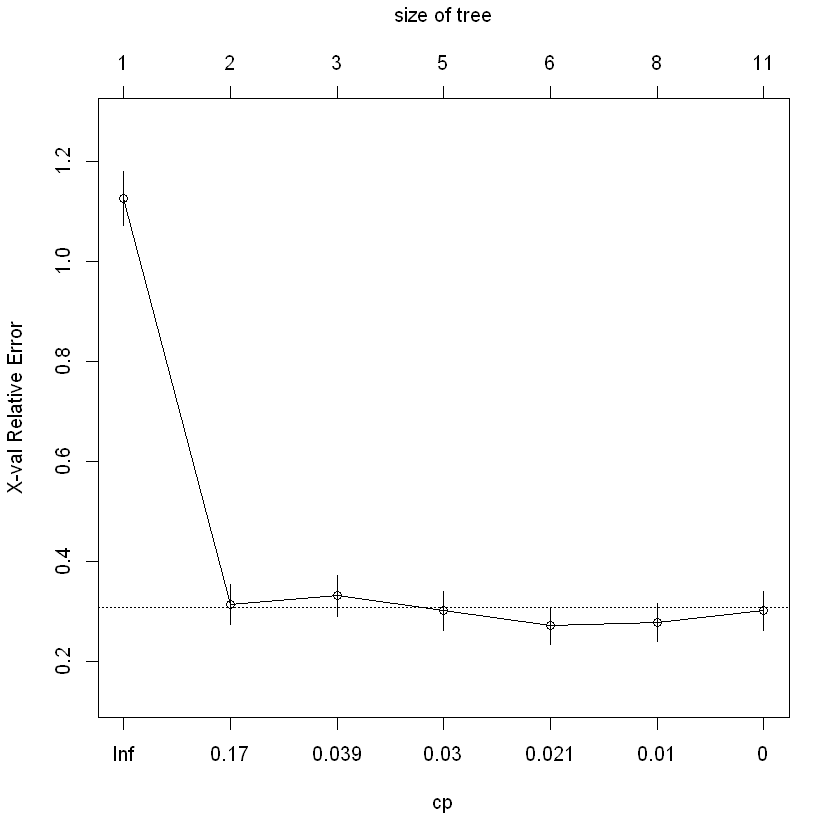

In [45]:
t1 = rpart(y~., data = XTrain, control=rpart.control(minsplit=best.minsplit,cp=0,xval=10))
print(t1)
plot(t1)
text(t1,cex=0.7)
printcp(t1)
plotcp(t1)

In [46]:
cat("La valeur de cp qui minimise la xerror est : ")
(best.cp = t1$cptable[which.min(t1$cptable[,"xerror"]),"CP"])

La valeur de cp qui minimise la xerror est : 

[1] 0.01807229

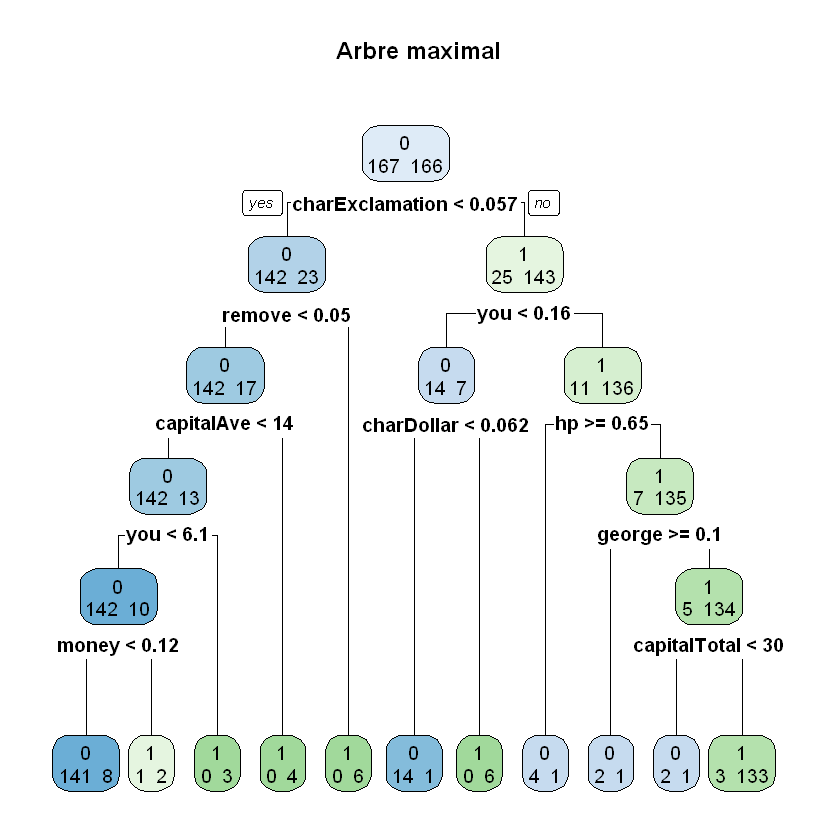

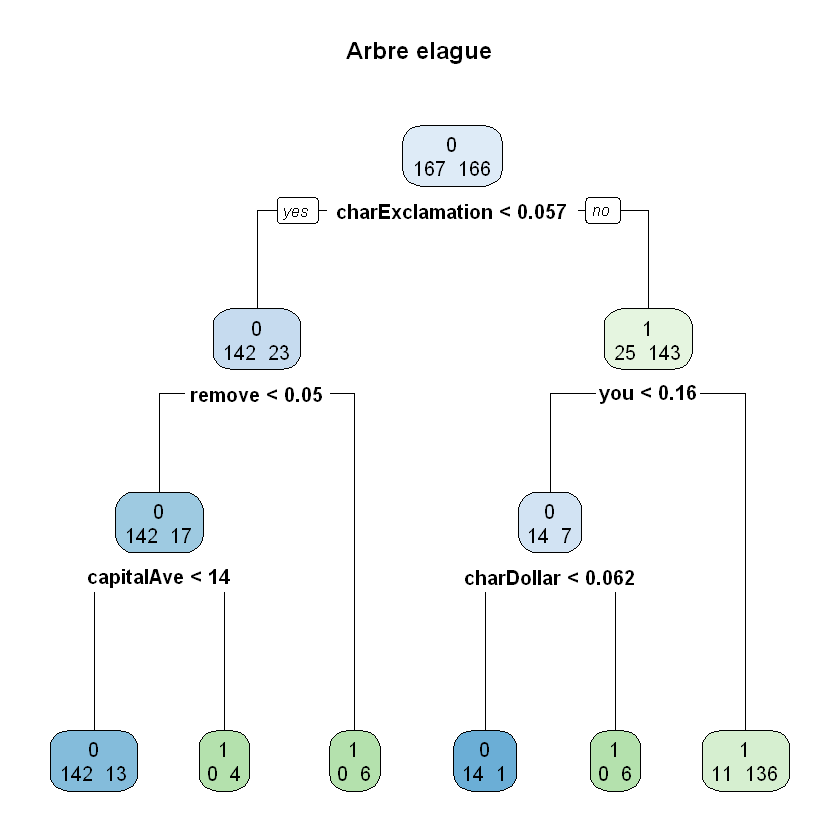

In [47]:
tprune = prune(t1, cp = best.cp)
rpart.plot(t1, extra = 1, main = "Arbre maximal")
rpart.plot(tprune, extra = 1, main = "Arbre elague")

### Calcul de l'erreur test de l'arbre complet et l'arbre elague

In [48]:
model_CART = rpart(y~., data = XTrain, control = rpart.control(minsplit = best.minsplit, cp = 0, xval = 10))
pred.CART = predict(model_CART, newdata = XTest, type = "class")
cat("\ Erreur test estimee pour model_CART : \n")
(score.cart1 = mean(XTest$y != pred.CART))

tprune_CART = prune(model_CART, cp = best.cp)
pred.pruned.CART = predict(tprune_CART, newdata = XTest, type = "class")
cat("\ Erreur test estimee pour tprune_CART : \n")
(score.cart2 = mean(XTest$y != pred.pruned.CART))

if (score.cart1 < score.cart2) {
    best.cart = model_CART
} else {
    best.cart = tprune_CART
}

 Erreur test estimee pour model_CART : 


[1] 0.07185629

 Erreur test estimee pour tprune_CART : 


[1] 0.1197605

## SVM

### Kernel lineaire

In [49]:
tune.svm.linear = tune(svm, y~., data = XTrain, kernel = "linear", ranges = list(cost = c(0.001, 0.01, 0.1, 1, 10)))
tune.svm.linear
best.svm.linear = tune.svm.linear$best.model
best.svm.linear.perf = tune.svm.linear$best.performance

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"V


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
    1

- best performance: 0.092959 


### Kernel radial

In [50]:
tune.svm.radial = tune(svm, y~., data = XTrain, kernel = "radial", 
                       ranges = list(cost = c(0.1, 1, 10), gamma = c(1e-05, 1e-04, 0.001, 0.01, 0.1)))
tune.svm.radial
best.svm.radial = tune.svm.radial$best.model
best.svm.radial.perf = tune.svm.radial$best.performance

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"V

"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x,

"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x,


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
   10 0.001

- best performance: 0.2011586 


### Kernel polynomial

### Kernel sigmoide

In [ ]:
tune.svm.poly = tune(svm, y~., data = XTrain, kernel = "polynomial", 
                     ranges = list(degree = c(2,3,4), cost = c(0.001, 0.01, 0.1), gamma = c(0.0001, 0.001, 0.01)))
tune.svm.poly
best.svm.poly = tune.svm.poly$best.model
best.svm.poly.perf = tune.svm.poly$best.performance

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"V

"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x,

"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x,

"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x,

"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'num3d' constant. Cannot scale data."Warning message in svm.default(x,

In [ ]:
tune.svm.sigmoid = tune(svm, y~., data = XTrain, kernel = "sigmoid", 
                        ranges = list(cost = c(1, 10, 100, 1000), gamma = c(0.0001, 0.001, 0.01, 0.1)))
tune.svm.sigmoid
best.svm.sigmoid = tune.svm.sigmoid$best.model
best.svm.sigmoid.perf = tune.svm.sigmoid$best.performance

### Determination du meilleur modele parmi les differents kernels

In [ ]:
perf = c(best.svm.linear.perf,best.svm.radial.perf,best.svm.poly.perf,best.svm.sigmoid.perf)
best.svm.perf = perf[which.min(perf)]
cat("Taux de mal classes : ")
best.svm.perf
if (best.svm.perf == tune.svm.linear$best.performance) {
    best.svm = best.svm.linear
} else if (best.svm.perf == tune.svm.radial$best.performance) {
    best.svm = best.svm.radial
} else if (best.svm.perf == tune.svm.poly$best.performance) {
    best.svm = best.svm.poly
} else if (best.svm.perf == tune.svm.sigmoid$best.performance) {
    best.svm = best.svm.sigmoid
}
cat("Meilleur modele SVM : ")
best.svm

### Calcul de l'erreur test

In [ ]:
table(true = XTest$y, pred = predict(best.svm, newdata = XTest))
cat("\nErreur de prediction : \n")
mean(XTest$y != predict(best.svm, newdata = XTest))

# Evaluation des methodes par courbes ROC

In [ ]:
### Regression Logistique
model_RL = glm(y~., data=XTrain, family = "binomial")
score.glm = predict(model_RL, newdata = XTest, type = "response")

### Random forest
model_RF = randomForest(y~., data = XTrain, ntree = best.rf.params$ntree, mtry = best.rf.params$mtry)
score.rf = predict(model_RF, newdata = XTest, type = "prob")


### CART
# model_CART_non_el = rpart(y~., data = XTrain, control = rpart.control(minsplit = 30, cp = 0, xval = 10))
# model_CART = prune(model_CART_non_el, cp = 0.048)
model_CART = best.cart
score.cart = predict(model_CART, newdata = XTest, type = "prob")

### SVM
if (best.svm$kernel == 0) {
    best.svm$kernel = "linear"
} else if (best.svm$kernel == 1) {
    best.svm$kernel = "polynomial"
}else if (best.svm$kernel == 2) {
    best.svm$kernel = "radial"
}else if (best.svm$kernel == 3) {
    best.svm$kernel = "sigmoid"
}

model_svm = svm(y~., data = XTrain, kernel = sprintf("%s", best.svm$kernel), 
                cost = sprintf("%s", best.svm$cost), 
                gamma = sprintf("%s", best.svm$gammma), 
                probability = TRUE, cross = 10)
score.svm = predict(model_svm, newdata = XTest, probability = TRUE)
score.svm = attr(score.svm, "probabilities") # probas de prediction

# seuil s
s=seq(0,1,.001)

# Initialisation RL
absc = numeric(length(s))
ordo = numeric(length(s))

# Initialisation RF
absc2 = numeric(length(s))
ordo2 = numeric(length(s))

# Initialisation CART
absc3 = numeric(length(s))
ordo3 = numeric(length(s))

# Initialisation SVM
absc4 = numeric(length(s))
ordo4 = numeric(length(s))

# Courbe ROC : taux de vrais positifs (TPR) en fonction du taux de faux positifs (FPR)
for (i in 1:length(s)){
  ordo[i]=sum(score.glm>=s[i] & XTest$y == "1")/sum(XTest$y == "1")
  absc[i]=sum(score.glm>=s[i] & XTest$y == "0")/sum(XTest$y == "0")
  
  ordo2[i]=sum(score.rf[,2]>=s[i] & XTest$y == "1")/sum(XTest$y == "1")
  absc2[i]=sum(score.rf[,2]>=s[i] & XTest$y == "0")/sum(XTest$y == "0")
  
  ordo3[i]=sum(score.cart[,2]>=s[i] & XTest$y == "1")/sum(XTest$y == "1")
  absc3[i]=sum(score.cart[,2]>=s[i] & XTest$y == "0")/sum(XTest$y == "0")
  
  ordo4[i]=sum(score.svm[,2]>=s[i] & XTest$y == "1")/sum(XTest$y == "1")
  absc4[i]=sum(score.svm[,2]>=s[i] & XTest$y == "0")/sum(XTest$y == "0")
}

plot(absc,ordo,type = "l",xlab="Taux de faux positifs",ylab ="Taux de vrais positifs",col="red", 
     main = "Courbes ROC")
lines(absc2,ordo2,col="blue")
lines(absc3,ordo3,col="green")
lines(absc4,ordo4,col="orange")
lines(s,s, lty = 2)
legend(x = 0.6, y = 0.4, c("Logistic Regression","Random Forest","CART","SVM"), 
       text.col = c("red","blue","green","orange"))

## Calcul des aires sous la courbe ROC

In [ ]:
library(AUC)
# creation d'un vecteur temporaire de la variable reponse car la fonction roc ne prend en compte que les labels 0 et 1.
yyy = XTest$y
levels(yyy)[levels(yyy)=="-1"]="0"

cat("Regression Logistique : ")
(auc.glm = auc(roc(score.glm, yyy)))
cat("\nRandom Forest : ")
(auc.rf = auc(roc(score.rf[,2], yyy)))
cat("\nSVM : ")
(auc.svm = auc(roc(score.svm[,2], yyy)))
cat("\nCART : ")
(auc.cart = auc(roc(score.cart[,2], yyy)))

auc.best = c(auc.glm, auc.rf, auc.svm, auc.cart)[which.max(c(auc.glm, auc.rf, auc.svm, auc.cart))]

# Selection du meilleur modele

In [ ]:
if (auc.best == auc.glm) {
    cat("\n Matrice de confusion de la Regression Logistique : \n")
    table(true = XTest$y, predicted = predict(model_GLM, newdata = XTest))
    best.model = model_RL
} else if (auc.best == auc.rf) {
    cat("\n Matrice de confusion de Random Forest : \n")
    table(true = XTest$y, predicted = predict(model_RF, newdata = XTest))
    best.model = model_RF
} else if (auc.best == auc.svm) {
    cat("\n Matrice de confusion de SVM : \n")
    table(true = XTest$y, predicted = predict(model_SVM, newdata = XTest))
    best.model = model_svm
} else if (auc.best == auc.cart) {
    cat("\ Matrice de confusion de CART : \n")
    table(true = XTest$y, predicted = predict(model_CART, newdata = XTest, type = "class"))
    best.model = model_CART
}

# Prediction sur un nouveau dataset en utilisant le meilleur modele

In [ ]:
filepath_test = file.choose(new = FALSE) # dataset sur lequel on veut faire les predictions
data_test = read.table(file = filepath_test, header = TRUE, sep = sep)

pred.final = predict(best.model, newdata = data_test, type = "prob", probability = TRUE)
head(pred.final)
ypred = pred.final[,2]

In [ ]:
output = readline(prompt = "Entrer le chemin du fichier de sorties : " )
write.table(ypred, file = output, sep = "\t", fileEncoding = "utf8", 
            row.names = FALSE, col.names = FALSE, dec = ".", quote = FALSE)